In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

SyntaxError: invalid syntax (PapilledemaLoader.py, line 177)

# Classification

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)


cuda:0 ['0', '1', '2', '3', '4', '5']


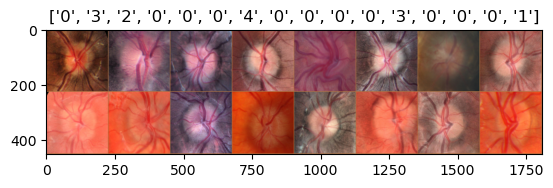

In [ ]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [ ]:
# siamese50simclr = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
siamese50simclr = get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')
siamese50simclr.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))

In [ ]:
# from torch.optim import lr_scheduler
import pytorch_warmup as warmup  
siamese50simclr = siamese50simclr.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': siamese50simclr.fc.parameters()}], lr=lr, momentum=momentum)
class_weights=torch.tensor([0.3, 1.28, 1.51, 1.31, 3.18, 11],dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)
warmup_scheduler = warmup.LinearWarmup(optimizer_ft, warmup_period=10)

for param in siamese50simclr.parameters():
    param.requires_grad = False
for param in siamese50simclr.fc.parameters():
    param.requires_grad = True

In [ ]:
# bestmodel = siamese50simclr
valaccmax = 0
for e in range(30):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in dataloaders['train']:
        siamese50simclr.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = siamese50simclr(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)

    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = siamese50simclr(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)

    if(val_acc >= valaccmax):
        valaccmax = val_acc
        print(f"New best mode at epoch {e}")
        torch.save(siamese50simclr.state_dict(), './pretrained/best-classification-siamese50simclr.pt')
        
    with warmup_scheduler.dampening(): 
        if warmup_scheduler.last_step + 1 >= 10:
            scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

New best mode at epoch 0
E0 With LR 0.002 training acc:  0.13859910581222057 Val acc:  0.10588235294117647 traning loss:  1.7852492048203856
E1 With LR 0.003 training acc:  0.14754098360655737 Val acc:  0.09411764705882353 traning loss:  1.7701757245554122
New best mode at epoch 2
E2 With LR 0.004 training acc:  0.16989567809239942 Val acc:  0.11764705882352941 traning loss:  1.7502881716686993
New best mode at epoch 3
E3 With LR 0.005 training acc:  0.15052160953800298 Val acc:  0.15294117647058825 traning loss:  1.7330784097691407
E4 With LR 0.006 training acc:  0.2444113263785395 Val acc:  0.12941176470588237 traning loss:  1.678057692267678
E5 With LR 0.006999999999999999 training acc:  0.33383010432190763 Val acc:  0.12941176470588237 traning loss:  1.5876341768597348
New best mode at epoch 6
E6 With LR 0.008 training acc:  0.3919523099850969 Val acc:  0.2235294117647059 traning loss:  1.480044376299385
New best mode at epoch 7
E7 With LR 0.009000000000000001 training acc:  0.3532

## Testing and Evaluation

In [ ]:
# bestmodel = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
bestmodel = get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
bestmodel.load_state_dict(torch.load('./pretrained/best-classification-siamese50simclr.pt'))
bestmodel.to(device)
clear_output()

In [ ]:
test_acc = 0
predlist = []
labelist = []
problist = []
test_embeddings = torch.zeros((0, 2048))
fextractor = torch.nn.Sequential(*(list(bestmodel.children())[:-1]))
sedis = 0
for inputs, labels in dataloaders['test']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
# test_embeddings = np.array(test_embeddings)

In [ ]:
sedis/dataset_sizes['test']

tensor(15.0626, device='cuda:0')

### F1 Acc Confusion Matrix AUC-ROC

In [ ]:
print("test_acc acc: ", test_acc / dataset_sizes['test'])

test_acc acc:  tensor(0.3978, device='cuda:0')


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.622     0.560     0.589        50
           1      0.273     0.333     0.300         9
           2      0.500     0.083     0.143        12
           3      0.000     0.000     0.000        13
           4      0.111     0.333     0.167         6
           5      0.231     1.000     0.375         3

    accuracy                          0.398        93
   macro avg      0.289     0.385     0.262        93
weighted avg      0.440     0.398     0.387        93



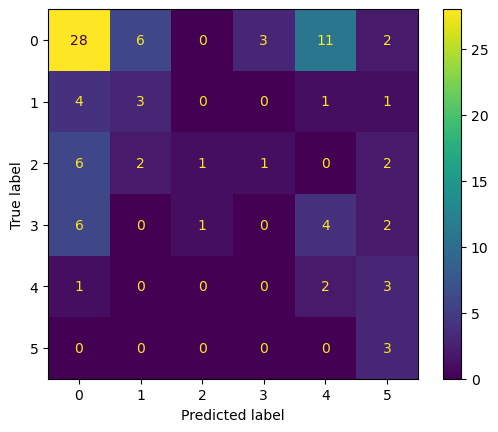

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
import sklearn.metrics as metrics

y_test = (labelist)
y_pred =(problist)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.grid(linestyle='--')
roc_auc_score(y_test, y_pred)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb9031645e0>
Traceback (most recent call last):
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/hongn/miniconda3/envs/xai/lib/python3.10/selectors.py", line 416, in select
    fd_event_list =

ValueError: multiclass format is not supported

### GradCAM

In [ ]:
# siamese50simclr = RankNet_wresnet(feature_extractor='resnet101', cotrain=False).fextractor
for param in bestmodel.parameters():
    param.requires_grad = True

In [ ]:
X, y = next(iter(dataloaders['test']))
print('True label : ', y, ' and predicted: ', torch.max(bestmodel(X.cuda()),1)[1])

True label :  tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])  and predicted:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


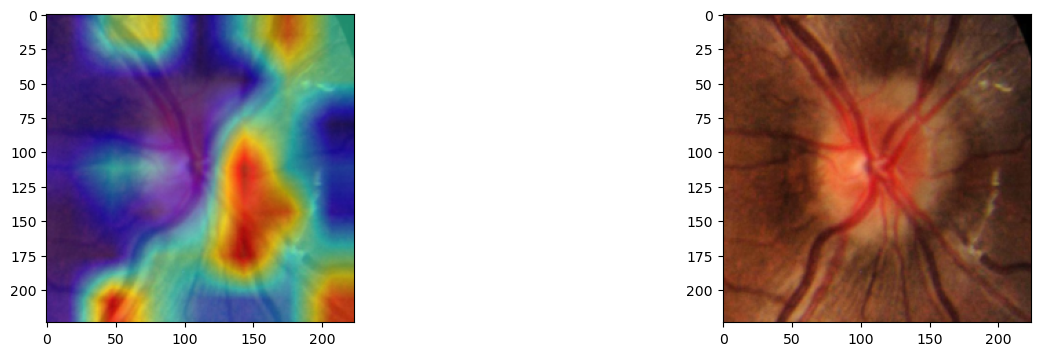

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model = bestmodel.eval()
target_layers = [model.layer4[-1]]

input_tensorA = X[0].unsqueeze(0)
rgb_imgA = imgtensor2array(X[0], mean=mean, std=std)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_camA = cam(input_tensor=input_tensorA, targets=[ClassifierOutputTarget(0)])

visualizationA = show_cam_on_image(rgb_imgA, grayscale_camA[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(visualizationA, label= 'heatmap A')
ax[1].imshow(rgb_imgA, label= 'heatmap A')


### Plot TSNE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
tsne = TSNE(2, verbose=1, n_iter=1000)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = predlist==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

ValueError: perplexity must be less than n_samples

# Similarity Comparison

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':100000, 'val':1000, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="binary_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


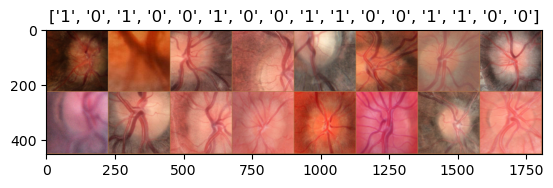

In [ ]:
(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [ ]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False , simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        cosine_distance = torch.nn.functional.cosine_similarity(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        # loss_contrastive =  torch.nn.NLLLoss()(cosine_distance)

        return loss_contrastive

In [ ]:
# from torch.optim import lr_scheduler
siamese50simclr = SiameseNetwork101().to(device)
momentum = 0
lr = 0.001
optimizer_ft = optim.SGD([{'params': siamese50simclr.cnn1.conv1.parameters()},
                        {'params': siamese50simclr.cnn1.layer1.parameters()},
                        {'params': siamese50simclr.cnn1.layer2.parameters()},
                        {'params': siamese50simclr.cnn1.layer3.parameters()},
                        {'params': siamese50simclr.cnn1.layer4.parameters()},
                        {'params': siamese50simclr.cnn1.fc.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = ContrastiveLoss(margin=2.0)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in siamese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in siamese50simclr.cnn1.fc.parameters():
    param.requires_grad = True

load simclr resnet


In [ ]:
valaccmax = 0
trainlosslist = []
trainacclist  = []
currloss = 100000
for e in range(100):
    training_acc = 0
    val_acc = 0
    training_loss = 0.0
    val_loss = 0.0
    for inputs, labels, _ in dataloaders['train']:
        siamese50simclr.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        output1, output2 = siamese50simclr(inputA, inputB)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss += loss.item()
        # training_acc += torch.sum(preds == labels.data)
    # trainlosslist.append(training_loss)
        # trainacclist.append(training_acc)
        
    for inputs, labels, _ in dataloaders['val']:
        siamese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = siamese50simclr(inputA, inputB)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            loss = loss_fn(output1, output2, labels)
            val_loss += loss.item()
            # val_acc += torch.sum(preds == labels.data)

    if(val_loss < currloss):
        currloss = val_loss
        today = date.today()
        torch.save(siamese50simclr.state_dict(), f'./pretrained/best-contrastive50-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", "traning loss: ", training_loss / dataset_sizes['train'], "val loss: ", val_loss / dataset_sizes['val'])

E0 With LR 0.001 training acc:  traning loss:  0.059109184148311615 val loss:  0.07084834843873977
E1 With LR 0.001 training acc:  traning loss:  0.046713675463199614 val loss:  0.07836902159452439
E2 With LR 0.001 training acc:  traning loss:  0.040007957869023086 val loss:  0.07851019471883774


KeyboardInterrupt: 

In [ ]:
plt.plot(torch.stack(val_loss).cpu()/1000)
# plt.plot(training_loss_test/1000)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not float

In [ ]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('./pretrained/best-contrastive50-2024-03-10.pt')
bestsimese50simclr.load_state_dict(state_dict)

load simclr resnet


<All keys matched successfully>

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['train']:
        bestsimese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = bestsimese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 256 but got size 4096 for tensor number 1 in the list.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.006905
[t-SNE] KL divergence after 1000 iterations: 1.813530


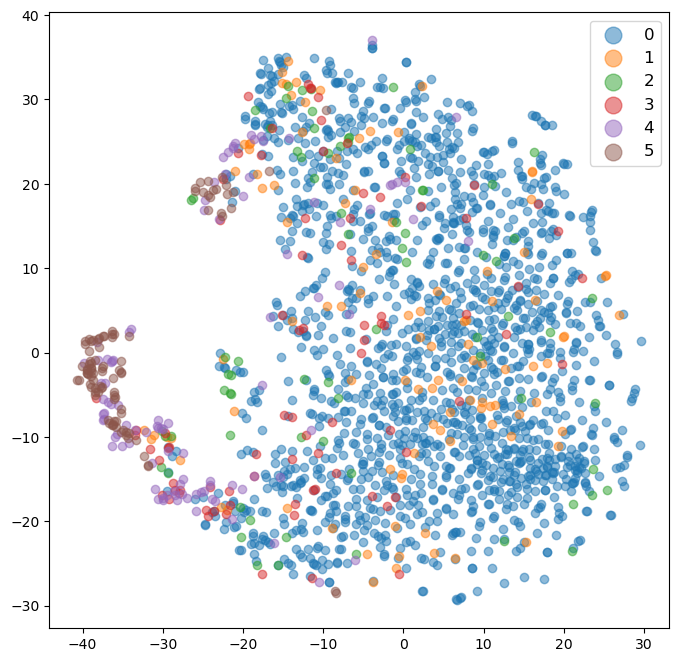

In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=30, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Prefered Comparison

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':10000, 'val':1000, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="severity_comparison") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


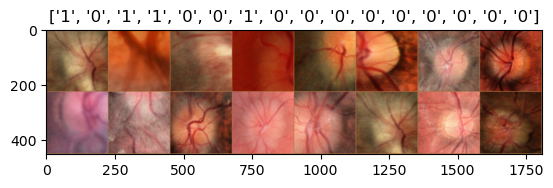

In [ ]:
(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [ ]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False)# , simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
class SeverityModel(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self, path2pretrained='./pretrained/best-contrastive50-2024-02-29.pt'):
        super(SeverityModel, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.bestsimese50simclr = SiameseNetwork101()
        state_dict = torch.load(path2pretrained)
        self.bestsimese50simclr.load_state_dict(state_dict)
        self.bestsimese50simclr.cnn1.add_module('fc2',
            nn.Sequential(torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
                        torch.nn.Dropout(0.1),
                        torch.nn.Linear(256, 256)))
    
    def forward_once(self, x):
        output = self.bestsimese50simclr.cnn1.fc2(self.bestsimese50simclr.cnn1(x))
        return output

    def forward(self, input1, input2, refinput):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        refinput = self.bestsimese50simclr.cnn1(refinput)
        return output1, output2, refinput

In [ ]:
class PreferenceComparisonLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(PreferenceComparisonLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, ref):
        # euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        cosine_distanceA = torch.nn.functional.cosine_similarity(output1, ref)
        cosine_distanceB = torch.nn.functional.cosine_similarity(output2, ref)
        loss_comparation = torch.nn.NLLLoss()(torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB), label)
        # loss_comparation = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))

        return loss_comparation

In [ ]:
smodel = SeverityModel(path2pretrained='./pretrained/best-contrastive50-2024-03-10.pt').to(device)
momentum = 0
lr = 0.001
optimizer_ft = optim.SGD([{'params': smodel.bestsimese50simclr.cnn1.conv1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer2.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer3.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer4.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc2.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = PreferenceComparisonLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in smodel.bestsimese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in smodel.bestsimese50simclr.cnn1.fc2.parameters():
    param.requires_grad = True

In [ ]:
valaccmax = 0
trainlosslist = []
trainacclist  = []

In [ ]:
# valaccmax = 0
# trainlosslist = []
# trainacclist  = []
# torch.set_grad_enabled(True)
for e in range(5):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    curr_loss = 100
    for inputs, labels, _ in dataloaders['train']:
        smodel.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
        ref = torch.stack(ref).to(device)
        output1, output2, refimg = smodel(inputA, inputB, ref)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels, refimg)
        # cosine_distanceA = torch.nn.functional.cosine_similarity(output1, refimg)
        # cosine_distanceB = torch.nn.functional.cosine_similarity(output2, refimg)
        # gamma = torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB)
        # loss = torch.nn.NLLLoss()(gamma, labels)
        # loss.requires_grad = True
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        # training_acc += torch.sum(preds == labels.data)
        # trainlosslist.append(training_loss_test)
        # trainacclist.append(training_acc)
        
    # for inputs, labels in dataloaders['val']:
    #     smodel.eval()
    #     inputA = inputs[0].to(device)
    #     inputB = inputs[1].to(device)
    #     labels = labels.to(device)

    #     with torch.no_grad():
    #         output1, output2 = siamese50simclr(inputA, inputB)
    #         preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
    #         # loss = loss_fn(inputA, inputB, labels)
    #         val_acc += torch.sum(preds == labels.data)

    if(training_loss_test < curr_loss):
        curr_loss = training_loss_test
        today = date.today()
        torch.save(smodel.state_dict(), f'./pretrained/best-smodel50-wofreeze-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}", "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.001 traning loss:  -0.031389243119955064
E1 With LR 0.001 traning loss:  -0.03173565866947174
E2 With LR 0.001 traning loss:  -0.033006256410479544
E3 With LR 0.001 traning loss:  -0.03425893153548241
E4 With LR 0.001 traning loss:  -0.03572028442621231


In [ ]:
bestsmodel = SeverityModel(path2pretrained='./pretrained/best-contrastive50-2024-02-25.pt').to(device)
state_dict = torch.load('./pretrained/best-smodel50-wofreeze.pt')
bestsmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = torch.stack(ref).to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.843742
[t-SNE] KL divergence after 1000 iterations: 0.388561


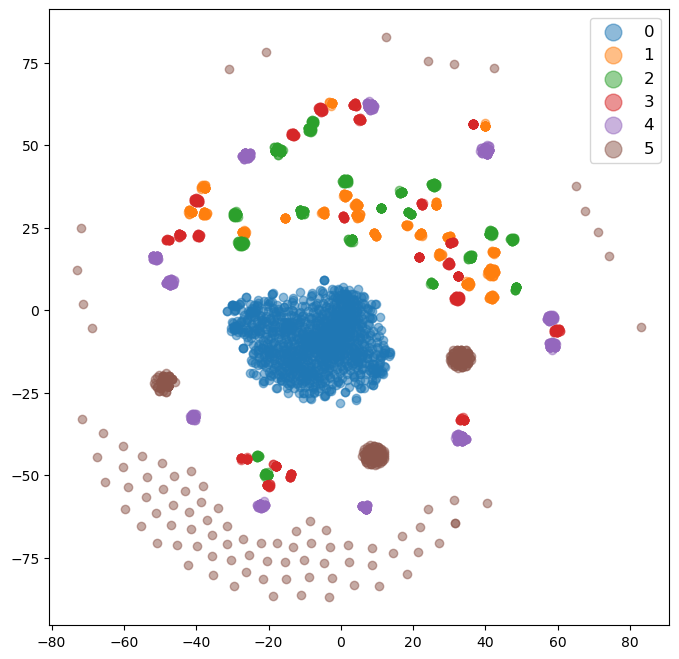

In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=50, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Explainable AI

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from captum.attr import IntegratedGradients, LimeBase
from captum.attr import GradientShap, KernelShap, FeatureAblation, FeaturePermutation,ShapleyValueSampling
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
X, y, meta = image_datasets['train'][50]

In [ ]:
meta

(1, 2)

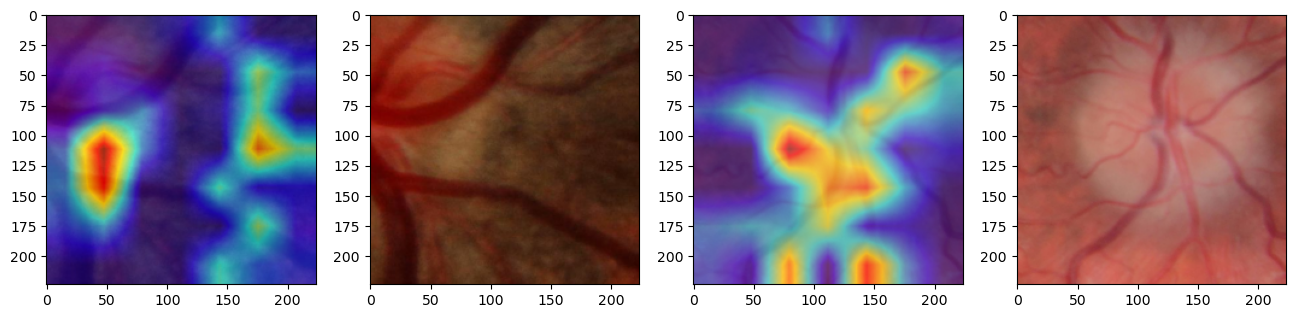

In [ ]:
# X,y,_ = image_datasets[4]
model = smodel.bestsimese50simclr.cnn1.cpu()
target_layers = [model.layer4[-1]]

# input_tensor = data_transforms['test'](Image.open("./datasets/longtitude/90007-L/90007-LU306-L.jpg")).unsqueeze(0) # Create an input tensor image for your model..
input_tensorA = X[0].unsqueeze(0)
input_tensorB = X[1].unsqueeze(0)

# Note: input_tensor can be a batch tensor with several images!
rgb_imgA = imgtensor2array(input_tensorA[0], mean=mean, std=std)
rgb_imgB = imgtensor2array(input_tensorB[0], mean=mean, std=std)
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

input_tensorA.requires_grad = True
input_tensorB.requires_grad = True
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_camA = cam(input_tensor=input_tensorA)
grayscale_camB = cam(input_tensor=input_tensorB)
# In this example grayscale_cam has only one image in the batch:

visualizationA = show_cam_on_image(rgb_imgA, grayscale_camA[0, :], use_rgb=True)
visualizationB = show_cam_on_image(rgb_imgB, grayscale_camB[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(visualizationA, label= 'heatmap A')
ax[1].imshow(rgb_imgA, label= 'heatmap A')
ax[2].imshow(visualizationB, label= 'heatmap A')
ax[3].imshow(rgb_imgB, label= 'heatmap A')

# Preference and Comparison

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':10000, 'val':1000, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="preference_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1','2']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2']


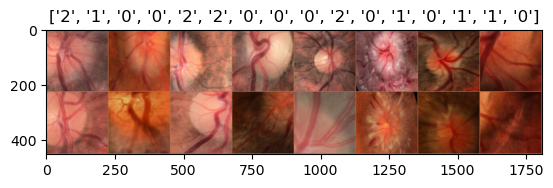

In [ ]:
(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [ ]:
class PreferenceContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(PreferenceContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, ref):
        total_loss = 0
        for i in label:
            # cosine_distanceA = torch.nn.functional.cosine_similarity(output1[i], ref)
            # cosine_distanceB = torch.nn.functional.cosine_similarity(output2[i], ref)
            # cosine_distance = torch.nn.functional.cosine_similarity(output1[i], output2[i])
            if(i == 2):
                cosine_distance = torch.nn.functional.cosine_similarity(output1[i], output2[i])
                total_loss = total_loss + (i) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2)
            else:
                cosine_distanceA = torch.nn.functional.cosine_similarity(output1[i], ref)
                cosine_distanceB = torch.nn.functional.cosine_similarity(output2[i], ref)
                total_loss = total_loss + torch.nn.CrossEntropyLoss()(torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB), i) 

        return total_loss/len(label)

In [ ]:
smodel = SeverityModel().to(device)
momentum = 0
lr = 0.05
optimizer_ft = optim.SGD([{'params': smodel.bestsimese50simclr.cnn1.parameters()}], lr=lr, momentum=momentum)
loss_fn = PreferenceComparisonLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

for param in smodel.bestsimese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in smodel.bestsimese50simclr.cnn1.fc2.parameters():
    param.requires_grad = True

In [ ]:
valaccmax = 0
trainlosslist = []
trainacclist  = []

In [ ]:
for e in range(10):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    curr_loss = 0
    for inputs, labels, _ in dataloaders['train']:
        smodel.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
        ref = torch.stack(ref).to(device)
        output1, output2, refimg = smodel(inputA, inputB, ref)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels, refimg)
        # cosine_distanceA = torch.nn.functional.cosine_similarity(output1, refimg)
        # cosine_distanceB = torch.nn.functional.cosine_similarity(output2, refimg)
        # gamma = torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB)
        # loss = torch.nn.NLLLoss()(gamma, labels)
        # loss.requires_grad = True
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        # training_acc += torch.sum(preds == labels.data)
        trainlosslist.append(training_loss_test)
        trainacclist.append(training_acc)
        
    # for inputs, labels in dataloaders['val']:
    #     smodel.eval()
    #     inputA = inputs[0].to(device)
    #     inputB = inputs[1].to(device)
    #     labels = labels.to(device)

    #     with torch.no_grad():
    #         output1, output2 = siamese50simclr(inputA, inputB)
    #         preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
    #         # loss = loss_fn(inputA, inputB, labels)
    #         val_acc += torch.sum(preds == labels.data)

    if(training_loss_test < curr_loss):
        curr_loss = training_loss_test
        torch.save(smodel.state_dict(), './pretrained/best-combine-smodel-wofreeze.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}", "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.05 traning loss:  -0.03226893329769373
E1 With LR 0.05 traning loss:  -0.0333457360625267
E2 With LR 0.05 traning loss:  -0.032826949079334734
E3 With LR 0.05 traning loss:  -0.033713542512059214
E4 With LR 0.05 traning loss:  -0.032140445947647096
E5 With LR 0.05 traning loss:  -0.031284525448083876
E6 With LR 0.05 traning loss:  -0.031234094738960265
E7 With LR 0.05 traning loss:  -0.03139525062441826
E8 With LR 0.05 traning loss:  -0.03200854330956936
E9 With LR 0.04000000000000001 traning loss:  -0.03253823267072439


In [ ]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/best-combine-smodel-wofreeze.pt')
bestsmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = torch.stack(ref).to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.494270
[t-SNE] KL divergence after 1000 iterations: 0.059347


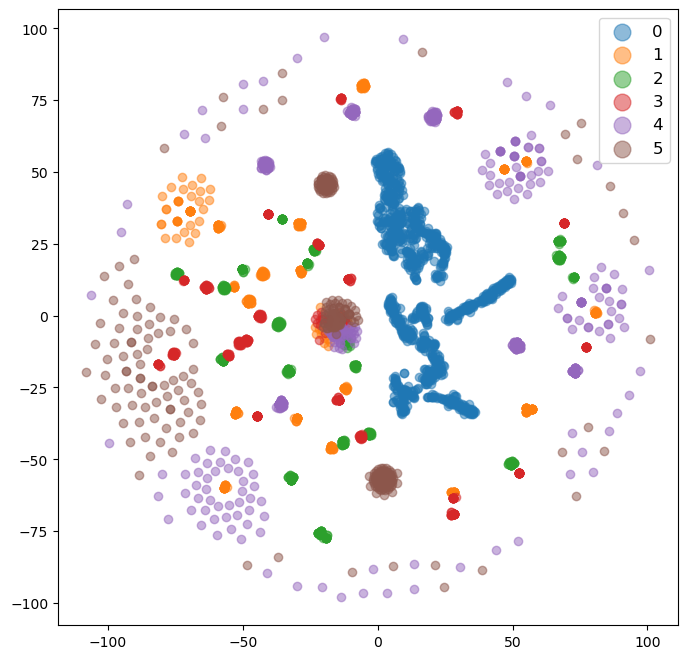

In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=30, early_exaggeration=10, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()